In [201]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

In [202]:
data = pd.read_csv('churn.csv')

In [203]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [204]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)

In [205]:
data['Gender'] = [1 if g == 'Male' else 0 for g in data['Gender']]

In [206]:
data.Geography = data.Geography.map({'Germany' : 3, 'Spain' : 2, 'France' : 1})

In [208]:
X = data.drop('Exited', axis = 1)
y = data.Exited

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ,random_state = 42, stratify = y)

In [210]:
lgbm = LGBMClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
cb = CatBoostClassifier(random_state = 42, verbose = 0)
rf = RandomForestClassifier(random_state = 42)
LR = LogisticRegression(random_state = 42)
svc = SVC(random_state = 42)
knn = KNeighborsClassifier()
mlp = MLPClassifier(random_state = 42)
gnb = GaussianNB()

In [43]:
models = [lgbm, xgb, cb, rf, LR, svc, knn, mlp, gnb]

In [44]:
acc_list = []

In [45]:
model_names = [model.__class__.__name__ for model in models]

In [46]:
for model in models :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    acc_list.append(acc)

[21:54:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
result = pd.DataFrame({'MODEL' : model_names, 'ACCURACY' : acc_list}).sort_values(by = 'ACCURACY', ascending = False)

In [53]:
result

,MODEL,ACCURACY
2,CatBoostClassifier,0.8720
0,LGBMClassifier,0.8640
3,RandomForestClassifier,0.8625
1,XGBClassifier,0.8465
4,LogisticRegression,0.7965
5,SVC,0.7965
8,GaussianNB,0.7875
6,KNeighborsClassifier,0.7640
7,MLPClassifier,0.7155


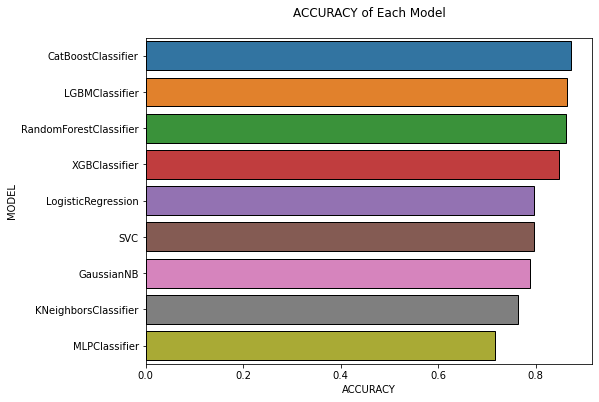

In [48]:
plt.figure(figsize = (8, 6))
plt.title('ACCURACY of Each Model\n', size = 12)
sns.barplot(y = result.MODEL, x = result.ACCURACY, edgecolor = (0, 0, 0))
plt.show()

## Voting - Soft

In [211]:
vot = VotingClassifier(estimators = [('lgbm', lgbm), ('cat', cb), ('rf', rf)],
                       voting = 'soft', weights = [0.35, 0.4, 0.25])
vot.fit(X_train, y_train)
vot_pred = vot.predict(X_test)
accuracy_score(y_test, vot_pred)

0.8675

In [212]:
vot = VotingClassifier(estimators = [('lgbm', lgbm), ('cat', cb), ('rf', rf)],
                       voting = 'hard', weights = [0.35, 0.4, 0.25])
vot.fit(X_train, y_train)
vot_pred = vot.predict(X_test)
accuracy_score(y_test, vot_pred)

0.869

## Stacking

In [213]:
stc = StackingClassifier(estimators = [('lgbm', lgbm), ('rf', rf)],
                         final_estimator = cb)
stc.fit(X_train, y_train)
stc_pred = stc.predict(X_test)
accuracy_score(y_test, stc_pred)

0.858

***
## Parameter Tuning

In [76]:
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

### - RandomForest

In [214]:
rf_params = {'max_depth' : [4, 5, 6, 7, 8], 'n_estimators' : [100, 200, 250, 300, 500]}

In [215]:
rf_grid = GridSearchCV(rf, rf_params, cv = skf, scoring = 'accuracy')
rf_grid.fit(X_train, y_train)
rf = RandomForestClassifier(random_state = 42, **rf_grid.best_params_)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy_score(y_test, pred)

0.867

In [82]:
rf_grid.best_params_

{'max_depth': 8, 'n_estimators': 500}

### - LightGBM

In [216]:
lgbm_params = {'max_depth' : [3, 4, 5, 6, 7], 'learning_rate' : [0.05, 0.1, 0.15, 0.2],
              'n_estimators' : [100, 200, 250, 300, 500]}

In [217]:
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv = skf, scoring = 'accuracy')
lgbm_grid.fit(X_train, y_train)
lgbm = LGBMClassifier(random_state = 42, **lgbm_grid.best_params_)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
accuracy_score(y_test, pred)

0.8645

In [218]:
lgbm_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}

### - CatBoost

In [219]:
cb_params = {'max_depth' : [3, 4, 5, 6, 7], 'learning_rate' : [0.05, 0.1, 0.15, 0.2],
              'iterations' : [100, 200, 250, 300, 500]}

In [220]:
cb_grid = GridSearchCV(cb, cb_params, cv = skf, scoring = 'accuracy')
cb_grid.fit(X_train, y_train)
cb = CatBoostClassifier(random_state = 42, **cb_grid.best_params_, verbose = 0)
cb.fit(X_train, y_train)
pred = cb.predict(X_test)
accuracy_score(y_test, pred)

0.869

In [221]:
cb_grid.best_params_

{'iterations': 200, 'learning_rate': 0.2, 'max_depth': 3}

***
## Blending

In [160]:
lgbm = LGBMClassifier(random_state = 42, **lgbm_grid.best_params_)
rf = RandomForestClassifier(random_state = 42, **rf_grid.best_params_)
cb = CatBoostClassifier(random_state = 42, verbose = 0)

In [163]:
lgbm.fit(X_train, y_train)
rf.fit(X_train, y_train)
cb.fit(X_train, y_train)

In [164]:
pred1 = lgbm.predict_proba(X_test)[:, 1]
pred2 = rf.predict_proba(X_test)[:, 1]
pred3 = cb.predict_proba(X_test)[:, 1]

In [177]:
final_pred = pred1 * 0.35 + pred2 * 0.25 + pred3 * 0.4

In [178]:
predictions = [1 if p >= 0.5 else 0 for p in final_pred]

In [179]:
accuracy_score(y_test, predictions)

0.8715